RMSE: 1.0891679212449632


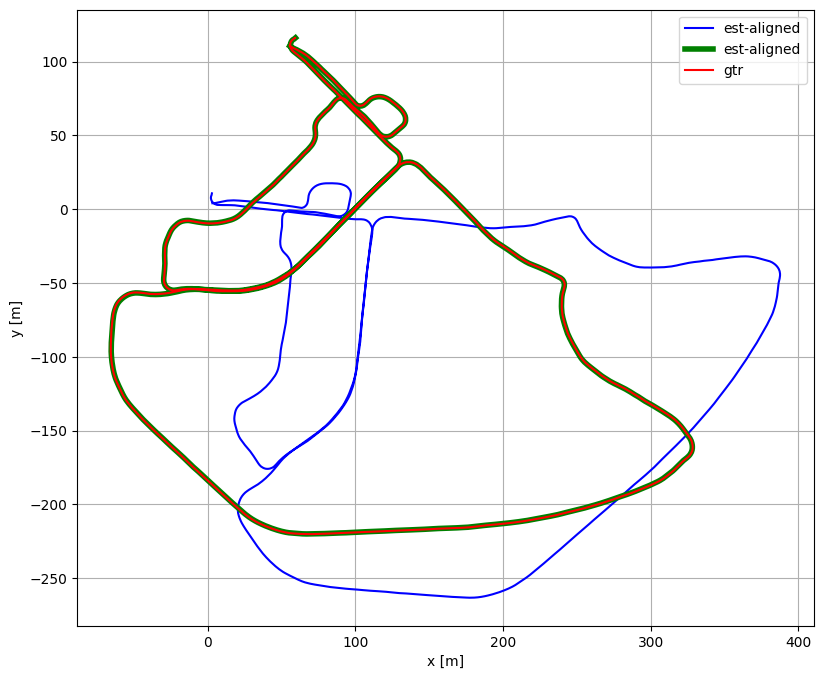

In [5]:
import numpy as np
import matplotlib.pyplot as plt

from evo.core import metrics
import evo.core.sync as sync
import evo.core.trajectory as evotraj

# Load estimated trajectory
est_traj = np.loadtxt('/home/dat/catkin_ws/mcd_ntu_day_04/KfCloudPoseOptimized.pcd', delimiter=' ', skiprows=11)

t_est = est_traj[:, 4]
p_est = est_traj[:, 0:3]
q_est = est_traj[:, [8, 5, 6, 7]]

# Load ground truth trajectory
gtr_traj = np.loadtxt('/home/dat/catkin_ws/mcd_ntu_day_04/groundtruth.csv', delimiter=',', skiprows=1)

t_gtr = gtr_traj[:, 0]
p_gtr = gtr_traj[:, [15, 16, 17]]
q_gtr = gtr_traj[:, [21, 18, 19, 20]]

# Create an evo trajectory for estimate
traj_est = evotraj.PoseTrajectory3D(positions_xyz=p_est, orientations_quat_wxyz=q_est, timestamps=t_est)

# Create an evo trajectory for ground truth
traj_gtr = evotraj.PoseTrajectory3D(positions_xyz=p_gtr, orientations_quat_wxyz=q_gtr, timestamps=t_gtr)

# Synchronize the trajectories (resample one trajectory by the timestamp of the other)
traj_est, traj_gtr = sync.associate_trajectories(traj_est, traj_gtr, max_diff=0.2)
traj_est.align(traj_gtr)
R_gtr_est, p_gtr_est, _= traj_est.align(traj_gtr)

# Transform original trajectory using the optimal transform from evo
p_est_alg = (R_gtr_est @ p_est.T).T + p_gtr_est

# Calculate the ATE
def calculate_metric(traj_gtr, traj_est):
    metric = metrics.APE(pose_relation=metrics.PoseRelation.translation_part)
    metric.process_data((traj_gtr, traj_est))
    return float(metric.get_result(ref_name='reference', est_name='estimate').stats['rmse'])
# Find the RMSE
rmse = calculate_metric(traj_est, traj_gtr)

print("RMSE:", rmse)

# Plot results
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(24, 8))
# ax.plot(p_est[:, 0], p_est[:, 1], color='b', label='est')
ax.plot(p_est_alg[:, 0], p_est_alg[:, 1], color='b', label='est-aligned')
ax.plot(traj_est.positions_xyz[:, 0], traj_est.positions_xyz[:, 1], color='g', label='est-aligned', linewidth=4)
ax.plot(p_gtr[:, 0], p_gtr[:, 1], color='r', label='gtr')
ax.set_aspect('equal')

ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.grid()

ax.legend()
plt.show()
